In [1]:
import argparse
import datetime
import json
import random
import logging
import os
import io
import sys
import duckdb

import numpy as np

from IPython.display import Image, display
from tqdm import tqdm
from pprint import pprint

from utils.utils import dynamic_import, load_config
from langchain_ollama import OllamaLLM, ChatOllama

from typing import Annotated, Union,Optional

from typing_extensions import TypedDict, Literal
from pydantic import BaseModel, field_validator, ValidationError, Field, model_validator

# from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, AnyMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.tools import BaseTool, tool

In [2]:
def setup_logger() -> logging.Logger:
    """Setup the logger configuration for consistency."""
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s [%(levelname)s] %(name)s: %(message)s",
        handlers=[logging.StreamHandler()],
    )
    return logging.getLogger(__name__)


logger = setup_logger()

## Get the data from the db

In [3]:
def get_text_from_db(conn, table_sections, pmcid):
    """
    Get the already recorded pmcids from db
    """
    cursor = conn.cursor()
    query = f"""
        SELECT abstract, SUBJECTS, METHODS
        FROM {table_sections} 
        WHERE pmcid = ?
    """
    cursor.execute(query, (pmcid,))
    row = cursor.fetchone()
    cursor.close()
    if row:
        abstract, subjects, method = row
        return abstract, subjects, method
    else:
        return None, None, None

In [6]:
# Load config
config_path = os.path.join("../config", "config.yaml")
config_all = load_config(config_path)

# DB connection
# # Name of the database
DB_FILE = config_all["api_europepmc_params"]["db_info_articles"]
table_status = config_all["db_params"]["table_status"]
table_sections = config_all["db_params"]["table_sections"]
table_metadata = config_all["db_params"]["table_metadata"]
table_inference = config_all["db_params"]["table_inference"]
# # Using duckdb to access the sqlite file for compatibility on marenostrum
conn = duckdb.connect(f"../{DB_FILE}")

# List of PMCID for testing

list_pmcids = [
 "PMC10167034", "PMC10191296",   "PMC10390885", "PMC1368980", "PMC2383879",   "PMC2693442", "PMC3041764", "PMC3145824", "PMC3174812", "PMC3212907", 
 "PMC3219398",  "PMC3534646", "PMC3804564", "PMC3909226", "PMC4029655", "PMC4393161", "PMC4640153", "PMC4928460", "PMC5040013", "PMC5308745", 
 "PMC5425199", "PMC5441889", "PMC5601641", "PMC5717332", "PMC5839230", "PMC5961641", "PMC6060212",   "PMC6076250", "PMC6286024","PMC6730009", 
 "PMC6760014", "PMC6775309", "PMC6853912", "PMC6858051", "PMC6955584", "PMC7007877", "PMC7449478", "PMC7657407", "PMC7661891", "PMC8155599", 
 "PMC8288503", "PMC8382172", "PMC8771850", "PMC8976245", "PMC9333080", "PMC9381901",   "PMC9529122", "PMC9616492", "PMC9697589"
]

pmcid_method = list()
for pmcid in list_pmcids[0:10]:
    
    abstract, subjects, method = get_text_from_db(conn, table_sections, pmcid)
    pmcid_method.append({'pmcid': pmcid, 'abstract': abstract, 'method': method, 'subjects': subjects})

In [7]:
## Instanciate LLMs
model_name = "qwen2.5:3b"
#model_name = "qwen2.5:latest"

llm = ChatOllama(model=model_name)
llm.temperature = 1


In [8]:
class PrivateState(BaseModel):
    pass
    
class DecisionState(BaseModel):
    article: dict = {}
    human_subjects: str = Field(default="", description="Does the article contain information about human subjects")
    sex_or_sample_data: bool = Field(default=False, description="Does the article contains information about the sex of the subjects")
    multi_sample: str = Field(default="", description="Does the research involves several samples")
    #one_subject: str = Field(default="", description="Does the samples provides from the same subject")
    
    multi_cohorts: str = Field(default="", description="Are there several cohorts")
    cohorts_overlap: str = Field(default="", description="Are some subjects present in more than one cohort")
    dropouts_before: str = Field(default="", description="Are there participants who drop the studies before the research started")
    dropouts_during: str = Field(default="", description="Are there participants who drop the studies during the research")
    droupouts_after: str = Field(default="", description="Are there participants who drop the studies after the research")
    info_text: bool = Field(default=False, description="Is the information contained in the text")
    info_table: bool = Field(default=False, description="Is the information contained in table")
    #results_explicit: bool = Field
    #results_implicit_sample_one_sex: bool = False
    #results_implicit_both_sex: bool = False
    #results_implicit_multi_cohorts: bool = False
    #results_implicit_matching_groups: bool = False
    #results_implicit_sample_one_sec_perc: bool = False
    #results_partial_data_after_dropout: bool = False
    #results_incomplete_data: bool = False
    #result_sex_specific_phenotype: bool = False

class ResultResponse(BaseModel):
    n_male: float = Field(default=np.nan, description="The total number of unique male reported in the paper")
    n_female: float = Field(default=np.nan, description="The total number of unique female reported in the paper")
    n_sample: float = Field(default=np.nan, description="The total number of unique participants reported in the paper")

class FinalResponse(DecisionState, ResultResponse):
    pass

In [9]:
# Tools

@tool
def extract_section_tool(document: dict, section: str) -> str:
    """
    Extracts a specific section (e.g., 'Abstract', 'Method', 'Result') from a single document dictionary.
    If the section does not exist, returns an empty string.
    """
    return document.get(section, "No content available.")


In [10]:
# Pydantic parsers
class DecisionParser(BaseModel):
    answer: str = Field(description="Must be either 'True', 'False', or 'Cannot decide'.")

    @model_validator(mode="before")
    @classmethod
    def preprocess_input(cls, values: dict) -> dict:
        #print("Preprocess_input called with values:", values)  # Debugging print
        raw_answer = values.get("answer")
        #print(f"Raw answer before processing: {raw_answer}")  # Debugging print
        if isinstance(raw_answer, str):
            try:
                # Attempt to parse the string as JSON
                parsed = json.loads(raw_answer)
                if isinstance(parsed, dict) and "answer" in parsed:
                    raw_answer = parsed["answer"]  # Extract the nested "answer"
            except json.JSONDecodeError:
                #print("Raw answer is not JSON.")  # Debugging print
                pass  # If not JSON, leave as-is

        # Update 'answer' in the dictionary
        values["answer"] = raw_answer
        #print(f"Processed answer: {values['answer']}")  # Debugging print
        return values

    @model_validator(mode="before")
    @classmethod
    def validate_answer(cls, values: dict) -> dict:
        #print("Validate_answer called with values:", values)  # Debugging print
        answer = values.get("answer")
        if answer not in {"True", "False", "Cannot decide"}:
            raise ValueError("Answer must be 'True', 'False', or 'Cannot decide'.")
        return values


In [11]:
def human_subject_decision(state: DecisionState) -> dict:
    """
    Determines if the article discusses human subjects by querying different sections of a single document.
    """
    print('Inside the human_subject_decision node')
    
    system_message = """
    You are a helpful assistant analyzing a scientific article. 
    You can call tools to extract specific sections of the document.
    """
    user_message = """
    Your task is to determine if the article consider human subjects for a study. 
    You can extract sections like Abstract, Method, or Result using the available tools.
    Answer as follows:
    - 'True': The document mentions human subjects.
    - 'False': The document does not mention human subjects.
    - 'Cannot decide': You cannot determine this from the available content.
    Use the tools provided to analyze the sections.
    Important: You need to answer the question following this format instructions:\n\n{format_instructions}
    """
  
    parser = PydanticOutputParser(pydantic_object=DecisionParser)

    
    chat_prompt = ChatPromptTemplate.from_messages([("system", system_message), ("user", user_message)])

    prompt_messages = chat_prompt.format_messages(article=state.article, format_instructions=parser.get_format_instructions())

    response = llm.invoke(prompt_messages)


    try:
        # print("Raw response content:", response.content.strip())
        parsed_response = parser.invoke(response.content.strip())
        # print("Parsed response:", parsed_response)  # Debugging print
    except ValueError as e:
        raise ValueError("Validation failed for model: " + str(e))

    return {"human_subjects": parsed_response.answer}

In [12]:
def human_subject_decision(state: DecisionState) -> dict:
    """
    Determines if the article discusses human subjects by querying different sections of a single document.
    """
    print("Inside the human_subject_decision node")

    system_message = """
    You are a helpful assistant analyzing a scientific article. You can call tools to extract specific sections of the document.
    """
    user_message = """
    Your task is to determine if the article mentions human subjects. You can extract sections like Abstract, Method, or Result using the available tools.
    Answer as follows:
    - 'True': The document mentions human subjects.
    - 'False': The document does not mention human subjects.
    - 'Cannot decide': You cannot determine this from the available content.
    Use the tools provided to analyze the sections.
    """

    parser = PydanticOutputParser(pydantic_object=DecisionParser)

    chat_prompt = ChatPromptTemplate.from_messages([("system", system_message), ("user", user_message)])

    # Provide the document and tool to the assistant
    tool_context = {
        "tools": [extract_section_tool],
        "tool_context": {
            "document": state.article  # Single document with 'Abstract', 'Method', 'Result'
        }
    }

    # Engage the assistant
    prompt_messages = chat_prompt.format_messages(
        format_instructions=parser.get_format_instructions()
    )

    response = llm.invoke(prompt_messages, **tool_context)

    try:
        parsed_response = parser.invoke(response.content.strip())
    except ValueError as e:
        raise ValueError("Validation failed for model: " + str(e))

    # Update the state with the assistant's final decision
    state.human_subjects = parsed_response.answer == "True"
    return {"human_subjects": parsed_response.answer}

In [13]:
def contain_sex_or_sample(state: DecisionState):
    """
    Checks for mentions of sex or sample details.
    """
    print(f"In contain_sex_or_sample node")

    keywords = ["male", "female", "sex", "gender", "women", "woman", "men", "man", "males", "females"]
    if any(keyword in state.article.lower() for keyword in keywords):
        print('In contain_sex: True')
        return {'sex_or_sample_data': True}
    else:
        print('In contain_sex: False')

        return {'sex_or_sample_data': False}

In [14]:
def multi_samples(state: DecisionState) -> str:
    """
    Determines if the article mentions sample from multi individuals, or if there are several participants
    """
    system_message = "You are a helpful assistant that needs to extract information from a scientific article from pubmed and follow the instruction given by the user"
    user_message = """Here is a scientific article. It contains experience and or survey about humans subject:\n\n{article}
    Your task is to understand if the reported experience are about several human subjects or about only one participant. 
    \t If the experience report to have more than one human subject or participant, answer 'True'.
    \t If it is not involving several humans or subjects and or several lines of tissues, cells, etc, answer 'False'.
    \t If you cannot take an informed decision, answer 'Cannot decide'.
    Important: You need to answer the question following this format instructions:\n\n{format_instructions}"""

    parser = PydanticOutputParser(pydantic_object=DecisionParser)
    
    chat_prompt = ChatPromptTemplate.from_messages([("system", system_message), ("user", user_message)])

    prompt_messages = chat_prompt.format_messages(article=state.article, format_instructions=parser.get_format_instructions())

    response = llm.invoke(prompt_messages)
    # print(f"Straight response: {response}")

    try:
        # print("Raw response content:", response.content.strip())
        parsed_response = parser.invoke(response.content.strip())
        # print("Parsed response:", parsed_response)  # Debugging print
    except ValueError as e:
        raise ValueError("Validation failed for model: " + str(e))

    return {"multi_sample": parsed_response.answer}

In [15]:
def multi_cohort(state: DecisionState) -> str:
    """
    Determines if there are several cohorts or studies in the same article.
    """
    system_message = "You are a helpful assistant that needs to extract information from a scientific article from pubmed and follow the instruction given by the user"
    user_message = """Here is a scientific article. It contains experience and or survey about humans subject:\n\n{article}
    Your task is to understand if the reported experience are about several human subjects or about only one participant. 
    \t If the experience report to have more than one human subject or participant, answer 'True'.
    \t If it is not involving several humans or subjects and or several lines of tissues, cells, etc, answer 'False'.
    \t If you cannot take an informed decision, answer 'Cannot decide'.
    Important: You need to answer the question following this format instructions:\n\n{format_instructions}"""

    parser = PydanticOutputParser(pydantic_object=DecisionParser)
    
    chat_prompt = ChatPromptTemplate.from_messages([("system", system_message), ("user", user_message)])

    prompt_messages = chat_prompt.format_messages(article=state.article, format_instructions=parser.get_format_instructions())

    response = llm.invoke(prompt_messages)
    # print(f"Straight response: {response}")

    try:
        # print("Raw response content:", response.content.strip())
        parsed_response = parser.invoke(response.content.strip())
        # print("Parsed response:", parsed_response)  # Debugging print
    except ValueError as e:
        raise ValueError("Validation failed for model: " + str(e))

    return {"multi_cohort": parsed_response.answer}


In [16]:
def participants_dropout(state: DecisionState) -> str:
    """
    Determines if there are several cohorts or studies in the same article.
    """
    system_message = "You are a helpful assistant that needs to extract information from a scientific article from pubmed and follow the instruction given by the user"
    user_message = """Here is a scientific article. It contains one study or one experience about human subjects humans subject:\n\n{article}
    In study it can happens that some participants are selected before the survey but eventually are removed for various reasons. 
    It can be also the case that participants are dropping out during the study or even after the study is done. 
    Your task is to analyse the text provided which details the method section. In there you need to figure out if there is such case of dropout.
    If partipants (or subjects) are removed before the ss
    \t If the experience report to have more than one human subject or participant, answer 'True'.
    \t If it is not involving several humans or subjects and or several lines of tissues, cells, etc, answer 'False'.
    \t If you cannot take an informed decision, answer 'Cannot decide'.
    Important: You need to answer the question following this format instructions:\n\n{format_instructions}"""

    parser = PydanticOutputParser(pydantic_object=DecisionParser)
    
    chat_prompt = ChatPromptTemplate.from_messages([("system", system_message), ("user", user_message)])

    prompt_messages = chat_prompt.format_messages(article=state.article, format_instructions=parser.get_format_instructions())

    response = llm.invoke(prompt_messages)
    # print(f"Straight response: {response}")

    try:
        # print("Raw response content:", response.content.strip())
        parsed_response = parser.invoke(response.content.strip())
        # print("Parsed response:", parsed_response)  # Debugging print
    except ValueError as e:
        raise ValueError("Validation failed for model: " + str(e))

    return {"multi_cohort": parsed_response.answer}


def participant_dropout_tools():
    return True

In [17]:
def extract_information(state: DecisionState) -> dict:
    """
    Extracts numerical data (e.g., number of males, females, total participants).
    """
    if state.multi_cohort == True:
        adding_message = 'There are several cohort in the article'
    else:
        adding_message = ''
    system_message = "You are a helpful assistant that needs to extract information from a scientific article from pubmed and follow the instruction given by the user"
    user_message = """Here is a scientific article. It contains experience and or survey about humans subject :\n\n{article}
    Your task is to understand if the reported experience are about several human subjects or about only one participant. 
    \t If the experience report to have more than one human subject or participant, answer 'True'.
    \t If it is not involving several humans or subjects and or several lines of tissues, cells, etc, answer 'False'.
    \t If you cannot take an informed decision, answer 'Cannot decide'.
    Important: You need to answer the question following this format instructions:\n\n{format_instructions}"""

In [27]:
def calculate_numbers(state: DecisionState) -> dict:
    """
    Extracts numerical data (e.g., number of males, females, total participants).
    """
    result_response = ResultResponse(
        n_male=50, 
        n_female=60, 
        n_sample=110
    )
    return {
        "n_male": result_response.n_male,
        "n_female": result_response.n_female,
        "n_sample": result_response.n_sample,
    }

In [28]:
def human_decision_router(state: DecisionState) -> str:
    print(f"In human_decision_router: {state.human_subjects}")
    if state.human_subjects == "True":
        return "contain_sex_or_sample"
    elif state.human_subjects == "False":
        return END
    elif state.human_subjects == 'Cannot decide':
        return END

def contain_sex_router(state: DecisionState) -> str:
    print(f"In contain_sex_router: {state.sex_or_sample_data}")
    if state.sex_or_sample_data == True:
        return "multi_samples"
    elif state.sex_or_sample_data == False:
        return END

def multi_sample_router(state: DecisionState) -> str:
    print(f"In multi_sample_router: {state.multi_sample}")
    if state.multi_sample == "True":
        return "multi_cohort"
    elif state.multi_sample == "False":
        return END
    elif state.multi_sample == 'Cannot decide':
        return END
def multi_cohort_router(state: DecisionState) -> str:
    print(f"In multi_sample_router: {state.multi_sample}")
    if state.multi_cohort == "True":
        return END
    elif state.multi_cohort == "False":
        return "participants_dropout"
    elif state.multi_cohort == 'Cannot decide':
        return END


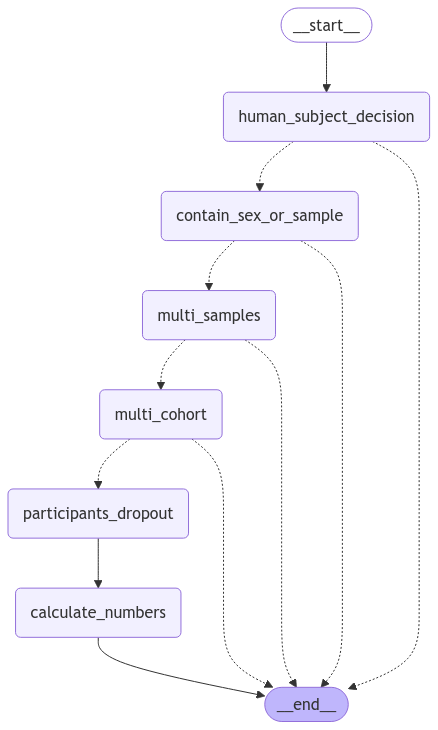

In [31]:
graph = StateGraph(DecisionState, output=FinalResponse)

graph.add_node("human_subject_decision", human_subject_decision)
graph.add_node("contain_sex_or_sample", contain_sex_or_sample)
graph.add_node("multi_samples", multi_samples)
graph.add_node("multi_cohort", multi_cohort)
graph.add_node("participants_dropout", participants_dropout)


graph.add_node("calculate_numbers", calculate_numbers)

graph.add_edge(START, "human_subject_decision")
graph.add_conditional_edges("human_subject_decision", human_decision_router,  path_map=["contain_sex_or_sample", END])
graph.add_conditional_edges("contain_sex_or_sample", contain_sex_router, path_map=["multi_samples", END])
graph.add_conditional_edges("multi_samples", multi_sample_router, path_map=["multi_cohort", END])
graph.add_conditional_edges("multi_cohort", multi_cohort_router, path_map=["participants_dropout", END])

graph.add_edge("participants_dropout", "calculate_numbers")
graph.add_edge("calculate_numbers", END)

graph = graph.compile()
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [26]:
for article in pmcid_method[2:]:

    initial_state = DecisionState(article=article)  # Call the initial_state like that otherwise DecisionState is not populated with default values
    result = graph.invoke(initial_state)  
    del result['article']
        print(f"Final answer: {result}")
        #try:
         #   print(result['human_subjects'], result["sex_or_sample_data"])
        #except KeyError:
         #   del result['article']
          #  print(result)

{'pmcid': 'PMC10390885', 'abstract': None, 'method': "Patients and Methods Study design This was an open-label, multicenter phase I clinical trial. The primary objective was to investigate the MTD and/or recommended phase II dose (RP2D) in patients with advanced or metastatic breast cancer. Secondary objectives included evaluation of the safety, antitumor activity at the RP2D, and pharmacokinetics of single and multiple doses of GDC-0927. The protocol was approved by Institutional Review Boards at participating institutions and written informed consent was obtained from patients prior to performing any procedures. The study was conducted in conformance with the ICH E6 guideline for Good Clinical Practice and the principles of the Declaration of Helsinki or the laws and regulations of the country in which the research was conducted, whichever afforded greater protection to the individual. Patients Postmenopausal women with histologic or cytologic diagnosis of locally assessed ER + /HER2

### 